# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [4]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [5]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
np.random.shuffle(test_target_shuffle)
print("RMSE with random baseline predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))


RMSE when predicting training data:
0.40439828823725865
RMSE when predicting testing data:
1.0667260022550893
RMSE with random baseline predictions:
5.311262511696229


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [6]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [8]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851357650711806


In [10]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384599, -1.08513577])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [11]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

#### The below graph shows the decrease of RMS error for every 5% increase in data. So we could potentially use to find what data size if reached beyond which training using larger data is not going to give us any better results

In [12]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

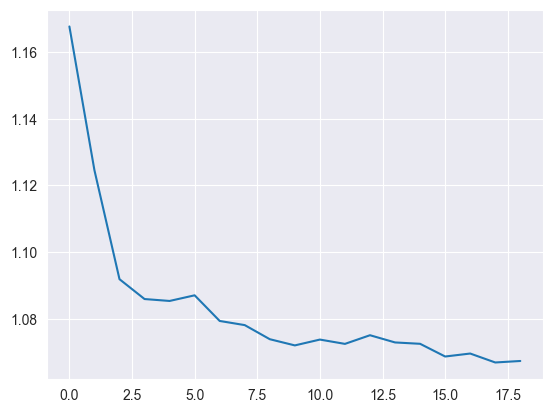

In [13]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [14]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    # print(df_hwk.head(2))

    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question:

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

- My prediction is that Alpha 0 will have better prediction than alpha =10 . Alpha = 10 adds the common element with a multiple. Due to this addition of the common valu multiple the prediction will be lesser accurtate , also the RMSE will be higher whrn alpha= 10

- I was wrong , the prediction actually came higher with alpha = 10 but the correlation was .993 which is too high and not acceptable so we cannot use it

- What I learn in this exercise is that we should look into multiple things before we come to conclusion on the best model like correlation, low p value , low RMSE  , and RMS for the train and test should be in similar range

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

- Implemented with  RandomizedSearchCV and found that the time for estimation was substantially reduced (16 minutes compared to 342 minutes with gridsearchCV). Also the best estimator was found to be similar to GridSearchCV

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [15]:
#X, y = make_X_y(10)

In [169]:
# Random forest regressor code for Gridsearch CV(cv=5) for hyperparmeter tuning with parameter grid with multiple depth values and n_estimators

# Adding exit so as not to execute this cell as it took a long time to execute and code looks good. I am not going to reexecute


from sklearn.model_selection import train_test_split
from scipy import stats

np.random.seed(0)

alpha_range = [0, 0.5, 1, 2, 5, 10]
#alpha_range = [0, 0.5]
result_df = pd.DataFrame()
#result_df = pd.DataFrame(columns=["alpha", "corr", "p_value", "best_estimator", "best_params", "best_score","rmse" ])

for alpha in alpha_range:
	X, y = make_X_y(alpha)   #generate X and y
	gcv = GridSearchCV(estimator = RandomForestRegressor(random_state=19), param_grid = {"n_estimators": [10, 33, 100, 300], "max_depth": [2, 4, 10,20, None]}, scoring = "neg_root_mean_squared_error", cv=5)
	# gcv = GridSearchCV(estimator = RandomForestRegressor(random_state=19), param_grid = {"n_estimators": [10, 33], "max_depth": [2, 4 ]}, scoring = "neg_root_mean_squared_error",cv=5)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	gcv.fit(X_train, y_train)
	y_pred_best = gcv.best_estimator_.predict(X_test)
	corr , p_value = stats.pearsonr(y_test, y_pred_best)
    # add to  a dataframe result_df and have columns alpha, corr, p_value best_estimator, best_params, best_score
	row_data= pd.DataFrame({"alpha" :[alpha], "corr" : [corr], "p_value" : [p_value], "best_estimator":[str(gcv.best_estimator_)], "best_params":[str(gcv.best_params_)], "best_score":[str(gcv.best_score_)] ,"rmse": [root_mean_squared_error(y_test, y_pred_best)]})
	result_df = pd.concat([result_df,row_data], ignore_index=True)
sorted_df_gcv = result_df.sort_values(by='corr', ascending=False)
print(sorted_df_gcv)

   alpha      corr        p_value  \
5   10.0  0.993134   0.000000e+00   
4    5.0  0.972423   0.000000e+00   
3    2.0  0.850638   0.000000e+00   
2    1.0  0.584103  2.722517e-183   
1    0.5  0.278646   5.467530e-37   
0    0.0  0.000515   9.816326e-01   

                                      best_estimator  \
5  RandomForestRegressor(max_depth=10, n_estimato...   
4  RandomForestRegressor(max_depth=10, random_sta...   
3  RandomForestRegressor(max_depth=10, n_estimato...   
2  RandomForestRegressor(max_depth=10, n_estimato...   
1  RandomForestRegressor(max_depth=4, n_estimator...   
0  RandomForestRegressor(max_depth=2, n_estimator...   

                              best_params           best_score      rmse  
5  {'max_depth': 10, 'n_estimators': 300}  -1.1986579056283304  1.166645  
4  {'max_depth': 10, 'n_estimators': 100}  -1.1862974118274066  1.193773  
3  {'max_depth': 10, 'n_estimators': 300}  -1.1560300022239516  1.165034  
2  {'max_depth': 10, 'n_estimators': 300}  -1.1

#### The below code is the Random forest regressor with Random searchCV with CV=5  with iteration count =10 , depth=1- n_estimators = 300

- Based on the computation time we see it took 16 minutes compared to 342 minute in the previous code with

- based on the output captured in the dataframe the best option is where alph =2  with a correlation of 0.85 as its meaningful relationship of price predictor stock and the target stock. It also has p value =0 . The hyperparameter identified is depth=10, number of estimator = 300 . The RMSE is 1.165 which is not very high and near the best compared to others.

- The best score(rmse for prediction) is .156 compared to the rmse (calculated on test scores by the model) is 1.1.65 which are comparable

#### Scoring research: Below are the options available

- ‘explained_variance’

- ‘neg_max_error’

- ‘neg_mean_absolute_error’

- ‘neg_mean_squared_error’   ...We can try this since this not square root so should penalize outliers

- ‘neg_root_mean_squared_error’  ...Used this on in code

- ‘neg_mean_squared_log_error’

- ‘neg_root_mean_squared_log_error’

- ‘neg_median_absolute_error’

- ‘r2’ (R square)    ... looks very common

- ‘neg_mean_poisson_deviance’

- ‘neg_mean_gamma_deviance’

- ‘neg_mean_absolute_percentage_error’

-‘d2_absolute_error_score’



In [167]:
# Here is the code to the RandomSearch CV with iteration count =5


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats

np.random.seed(0)

alpha_range = [0, 0.5, 1, 2, 5, 10]
#alpha_range = [0, 0.5]
result_df = pd.DataFrame()
#result_df = pd.DataFrame(columns=["alpha", "corr", "p_value", "best_estimator", "best_params", "best_score","rmse" ])

for alpha in alpha_range:
	X, y = make_X_y(alpha)   #generate X and y
	rsCV = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=19), param_distributions = {"n_estimators": [10, 33, 100, 300], "max_depth": [2, 4, 10, 30, None]}, scoring = "neg_root_mean_squared_error", cv=5, n_iter=10, random_state=42)
	# gcv = GridSearchCV(estimator = RandomForestRegressor(random_state=19), param_grid = {"n_estimators": [10, 33], "max_depth": [2, 4 ]}, scoring = "neg_root_mean_squared_error",cv=5)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	rsCV.fit(X_train, y_train)
	y_pred_best = rsCV.best_estimator_.predict(X_test)
	corr , p_value = stats.pearsonr(y_test, y_pred_best)
    # add to  a dataframe result_df and have columns alpha, corr, p_value best_estimator, best_params, best_score
	row_data= pd.DataFrame({"alpha" :[alpha], "corr" : [corr], "p_value" : [p_value], "best_estimator":[str(rsCV.best_estimator_)], "best_params":[str(rsCV.best_params_)], "best_score":[str(rsCV.best_score_)] ,"rmse": [root_mean_squared_error(y_test, y_pred_best)]})
	result_df = pd.concat([result_df,row_data], ignore_index=True)
sorted_df = result_df.sort_values(by='corr', ascending=False)
print(sorted_df)

   alpha      corr        p_value  \
5   10.0  0.993134   0.000000e+00   
4    5.0  0.972555   0.000000e+00   
3    2.0  0.850638   0.000000e+00   
2    1.0  0.584103  2.722517e-183   
1    0.5  0.276582   1.904396e-36   
0    0.0  0.000515   9.816326e-01   

                                      best_estimator  \
5  RandomForestRegressor(max_depth=10, n_estimato...   
4  RandomForestRegressor(max_depth=10, n_estimato...   
3  RandomForestRegressor(max_depth=10, n_estimato...   
2  RandomForestRegressor(max_depth=10, n_estimato...   
1  RandomForestRegressor(max_depth=4, n_estimator...   
0  RandomForestRegressor(max_depth=2, n_estimator...   

                              best_params           best_score      rmse  
5  {'n_estimators': 300, 'max_depth': 10}  -1.1986579056283304  1.166645  
4  {'n_estimators': 300, 'max_depth': 10}  -1.1865526910235216  1.190813  
3  {'n_estimators': 300, 'max_depth': 10}  -1.1560300022239516  1.165034  
2  {'n_estimators': 300, 'max_depth': 10}  -1.1

### After research on other scoring methods decided to use MSE which is supposed to penalize oultiers compared to RMSE method.  Here is the code for scoring method changed  'negative_mean_squared_error' with all parameter same as above and iterations=10 for RandomizedSearchCV

In [168]:

# Here is the code to the RandomSearch CV with iteration count =10
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats
#adding the below import so we can calculate the meansquared error
from sklearn.metrics import mean_squared_error

np.random.seed(0)

alpha_range = [0, 0.5, 1, 2, 5, 10]
#alpha_range = [0, 0.5]
result_df = pd.DataFrame()
#result_df = pd.DataFrame(columns=["alpha", "corr", "p_value", "best_estimator", "best_params", "best_score","rmse" ])

for alpha in alpha_range:
	X, y = make_X_y(alpha)   #generate X and y
	rsCV = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=19), param_distributions = {"n_estimators": [10, 33, 100, 300], "max_depth": [2, 4, 10, 30, None]}, scoring = "neg_mean_squared_error", cv=5, n_iter=10, random_state=42)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	rsCV.fit(X_train, y_train)
	y_pred_best = rsCV.best_estimator_.predict(X_test)
	corr , p_value = stats.pearsonr(y_test, y_pred_best)
    # add to  a dataframe result_df and have columns alpha, corr, p_value best_estimator, best_params, best_score
	row_data= pd.DataFrame({"alpha" :[alpha], "corr" : [corr], "p_value" : [p_value], "best_estimator":[str(rsCV.best_estimator_)], "best_params":[str(rsCV.best_params_)], "best_score":[str(rsCV.best_score_)] ,"rmse": [mean_squared_error(y_test, y_pred_best)]})
	result_df = pd.concat([result_df,row_data], ignore_index=True)
sorted_df_neg_mean_squared = result_df.sort_values(by='corr', ascending=False)
print(sorted_df_neg_mean_squared)

   alpha      corr        p_value  \
5   10.0  0.993134   0.000000e+00   
4    5.0  0.972555   0.000000e+00   
3    2.0  0.850638   0.000000e+00   
2    1.0  0.584103  2.722517e-183   
1    0.5  0.276582   1.904396e-36   
0    0.0  0.000515   9.816326e-01   

                                      best_estimator  \
5  RandomForestRegressor(max_depth=10, n_estimato...   
4  RandomForestRegressor(max_depth=10, n_estimato...   
3  RandomForestRegressor(max_depth=10, n_estimato...   
2  RandomForestRegressor(max_depth=10, n_estimato...   
1  RandomForestRegressor(max_depth=4, n_estimator...   
0  RandomForestRegressor(max_depth=2, n_estimator...   

                              best_params           best_score      rmse  
5  {'n_estimators': 300, 'max_depth': 10}   -1.437172599424623  1.361060  
4  {'n_estimators': 300, 'max_depth': 10}  -1.4081291749903821  1.418036  
3  {'n_estimators': 300, 'max_depth': 10}  -1.3364981254359118  1.357303  
2  {'n_estimators': 300, 'max_depth': 10}  -1.2

#### we see in the above the MSE is 1.4371 (i.e if we do square root- 1.198) which is slightly higher but not that high compared to the rmse reported with the rmse method(value 1.166) of scoring which shows there were not lot of outliers . The overall parameter and hyper parameter still remains the same. I will research a bit more on the other scoring methods and experiment a bit as this looks very useful

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

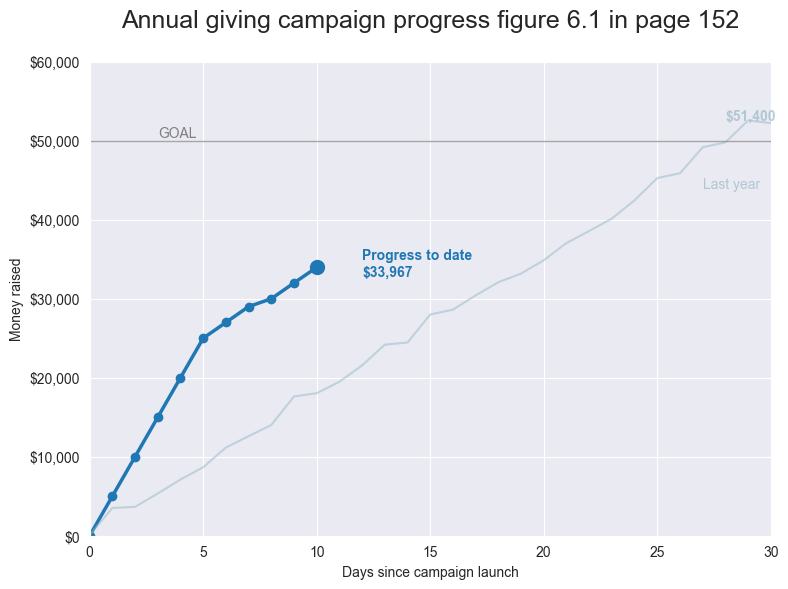

In [16]:
# creating figure 6.1 in page 152 "Annual giving campaign progress"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# create data
days = np.arange(0, 31)  # Changed from days_launch to days

# This year's progress (current campaign)
current_year = np.zeros(31)
current_year[1:11] = np.array([5000, 10000, 15000, 20000, 25000, 27000, 29000, 30000, 32000, 33967])

#create data fro last year with some noise added
last_year = np.linspace(0, 52000, 31)
noise = np.random.exponential(scale=1000, size=last_year.shape)

last_year = last_year + noise  # Adding noise to last year's data


fig, ax = plt.subplots(figsize=(8, 6))


#Ssearched google to get nice color "what are different blue color values" search query
ax.plot(days[:11], current_year[:11], 'o-', color='#1f77b4', linewidth=2.5, label='Progress to date')
ax.plot(days, last_year, '-', color='#95B9C7', alpha=0.5, linewidth=1.5, label='Last year')

# make bold the current amount
ax.plot(10, current_year[10], 'o', color='#1f77b4', markersize=10)
ax.annotate(f'$33,967',
            xy=(10, current_year[10]),
            xytext=(12, current_year[10] - 1000),
            color='#1f77b4',
            fontweight='bold')

# add horizontal line for the goal on top
goal_amount = 50000
ax.axhline(y=goal_amount, color='gray', linestyle='-', alpha=0.7, linewidth=1)
ax.annotate('GOAL',
            xy=(0, goal_amount),
            xytext=(3, goal_amount + 500),
            color='gray')

# last year's colelction amount
ax.annotate(f'$51,400',
            xy=(30, last_year[30]),
            xytext=(28, last_year[30] + 500),
            color='#95B9C7',
            alpha=0.7,
            fontweight='bold')

# Add text labels
ax.text(12, 35000, 'Progress to date', color='#1f77b4', fontweight='bold')
ax.text(27, 44000, 'Last year', color='#95B9C7', alpha=0.7)

# Add label and limits of axes
ax.set_xlim(0, 30)
ax.set_ylim(0, 60000)
ax.set_xlabel('Days since campaign launch')
ax.set_ylabel('Money raised')

# google search matplotlib.ticker customize tick labels  shows funcformatter
from matplotlib.ticker import FuncFormatter
def currency_formatter(x, pos):
    return f'${int(x):,}'
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Set title
ax.set_title('Annual giving campaign progress figure 6.1 in page 152', fontsize=18, pad=25)

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()